In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo
from matplotlib.ticker import MaxNLocator

plt.style.use("ggplot")

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.




### 1. User input

In [4]:
# Vannmiljø params
vm_st_yr = 2014
vm_end_yr = 2020
vm_stn_ids = [
    "126-54258",
]
vm_par_ids = ["P-TOT", "N-TOT"]

# TEOTIL3 params
reg_id = "126.4Z"
teo_st_yr = 2020
teo_end_yr = 2023
totp_ges_ugpl = 29
totn_ges_ugpl = 775
nve_data_year = 2024
admin_year = 2023

# Vann-nett params
vn_st_yr = 2014
vn_end_yr = 2020
totn_ugpl = 4886
totp_ugpl = 237

agri_loss_model = "annual"

### 2. TEOTIL modelling

#### 2.1. Read output

In [5]:
# Get regines
reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year)

# Read single input file and build network
data_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
csv_path = os.path.join(
    data_fold,
    f"agri_{agri_loss_model}_loss",
    f"teotil3_input_data_nve{nve_data_year}_2013.csv",
)
in_df = pd.read_csv(csv_path)
g = teo.model.build_graph(in_df, id_col="regine", next_down_col="regine_down")

# Read model results
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"
mod_csv = os.path.join(
    eval_fold,
    f"teo3_results_nve{nve_data_year}_2013-2023_agri-{agri_loss_model}-loss.csv",
)
mod_df = pd.read_csv(mod_csv)

mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,125.911370,0.752367,3.420677,6341.957245,69.787520,195.698890,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712744,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


#### 2.2. Plot catchment and results

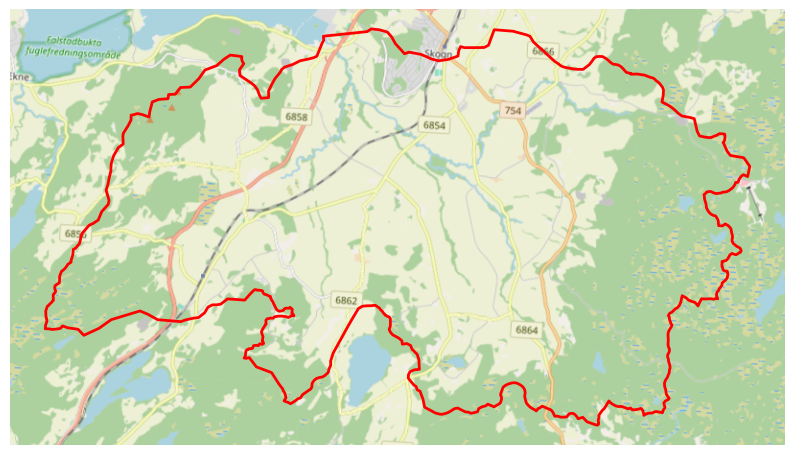

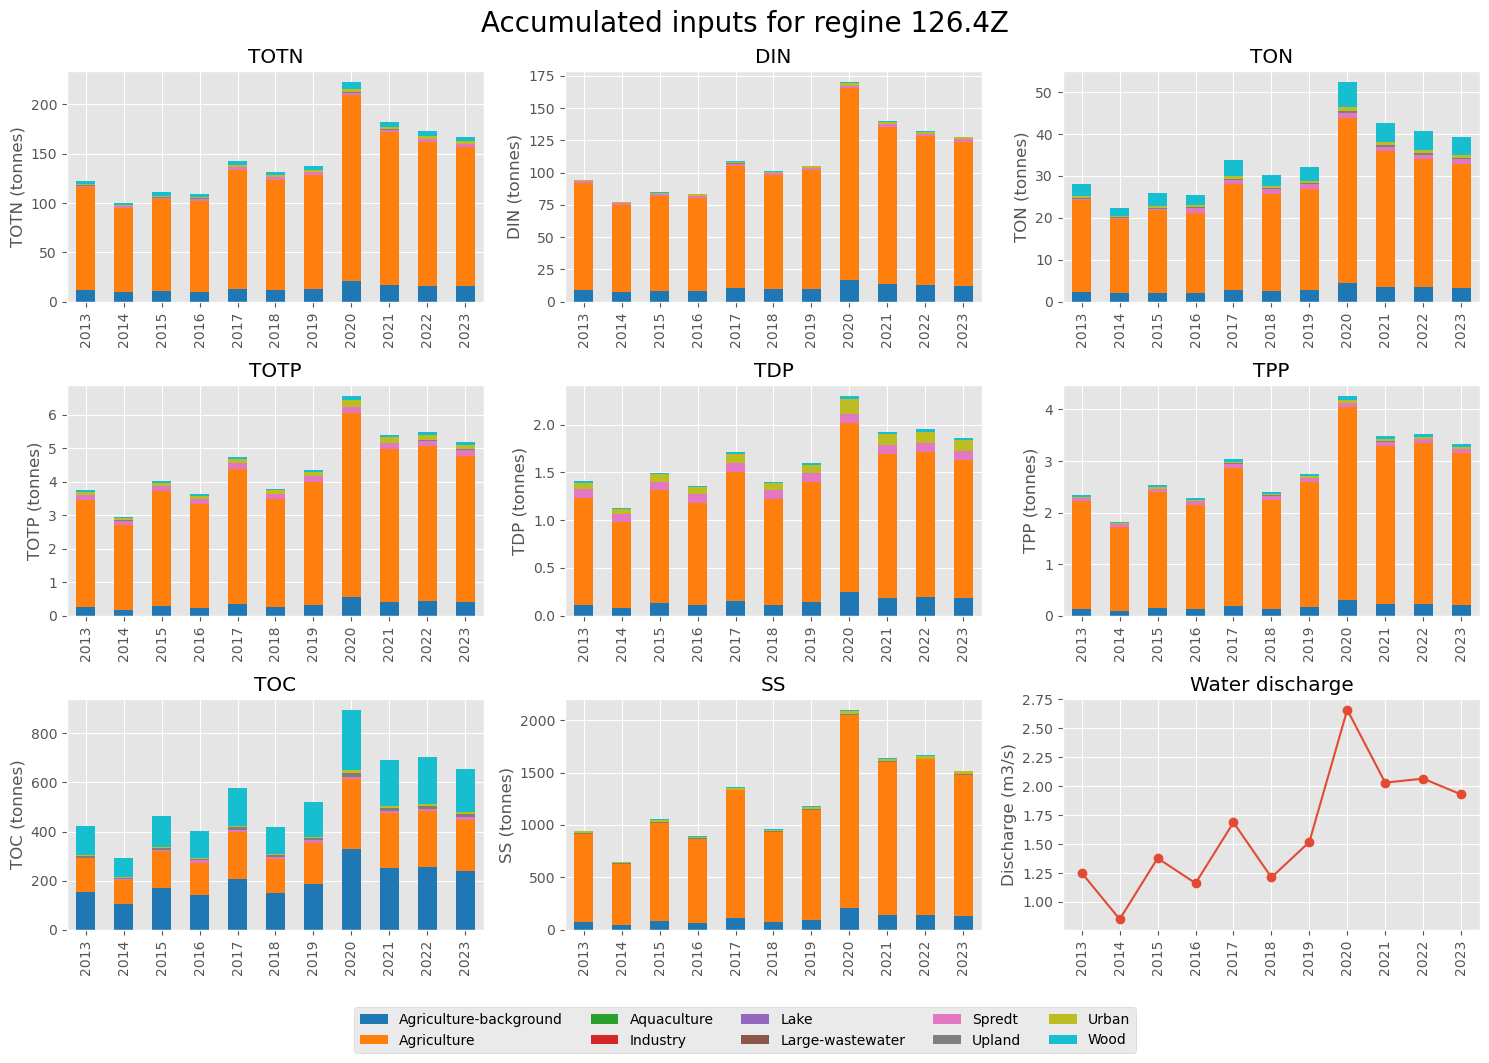

In [6]:
# Plot regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g,
    reg_id,
    reg_gdf,
    id_col="regine",
    include_connected=True,
    direct="up",
    basemap=r"https://tile.openstreetmap.org/{z}/{x}/{y}.png",
)
axes = teo.vis.plot_regine_barchart(reg_id, mod_df, stat="accum", index_col="year")

#### 2.3. Avlastningsbehov

In [7]:
totp_res_dict = teo.model.get_avlastningsbehov(
    reg_id,
    "TOTP",
    totp_ges_ugpl,
    mod_df,
    st_yr=teo_st_yr,
    end_yr=teo_end_yr,
    index_col="year",
)

Selected regine:	126.4Z.
Selected parameter:	TOTP.
Time period:		2020 to 2023.
Concentration for GES:	29 ug/l.

The regine contains 4 lake(s):
	vatnLnrs:	[37122, 38315, 38299, 38297]

Estimated mean outflow concentration(s) (2020-2023):
	TOTP (ug/l)                         83.0
	TDP (ug/l)                          29.5
	TPP (ug/l)                          53.5

Estimated mean annual outflow flux(es) (2020-2023):
	TOTP (kg)                           5659
	TDP (kg)                            2008
	TPP (kg)                            3651

Source apportionment for outflow TOTP:
	Agriculture (%)                     84.4
	Agriculture-background (%)           7.9
	Spredt (%)                           3.1
	Urban (%)                            2.9
	Wood (%)                             1.6
	Upland (%)                           0.2

Maximum outflow flux for GES (kg/yr)	    1988
Transmission factor (weighted) for TOTP     0.59
Maximum inflow flux for GES (kg/yr)	    3382
Estimated inflow flux 202

In [8]:
totn_res_dict = teo.model.get_avlastningsbehov(
    reg_id,
    "TOTN",
    totn_ges_ugpl,
    mod_df,
    st_yr=teo_st_yr,
    end_yr=teo_end_yr,
    index_col="year",
)

Selected regine:	126.4Z.
Selected parameter:	TOTN.
Time period:		2020 to 2023.
Concentration for GES:	775 ug/l.

The regine contains 4 lake(s):
	vatnLnrs:	[37122, 38315, 38299, 38297]

Estimated mean outflow concentration(s) (2020-2023):
	TOTN (ug/l)                       2721.6
	DIN (ug/l)                        2081.6
	TON (ug/l)                         640.0

Estimated mean annual outflow flux(es) (2020-2023):
	TOTN (kg)                         186113
	DIN (kg)                          142344
	TON (kg)                           43769

Source apportionment for outflow TOTN:
	Agriculture (%)                     84.5
	Agriculture-background (%)           9.4
	Wood (%)                             2.8
	Urban (%)                            1.5
	Spredt (%)                           1.5
	Upland (%)                           0.3
	Lake (%)                             0.0

Maximum outflow flux for GES (kg/yr)	   53115
Transmission factor (weighted) for TOTN     0.97
Maximum inflow flux for GES

### 3. Get data from Vannmiljø

In [9]:
# Query results from VM API
data = {
    "FromDateSamplingTime": f"{vm_st_yr}-01-01",
    "ToDateSamplingTime": f"{vm_end_yr}-12-31",
    "FromRegDate": "1900-01-01",
    "WaterLocationCodeFilter": vm_stn_ids,
}
obs_df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=data)
obs_df = obs_df.query("ParameterID in @vm_par_ids")
obs_df["SamplingTime"] = pd.to_datetime(obs_df["SamplingTime"])
obs_df["Year"] = obs_df["SamplingTime"].dt.year
cols = [
    "WaterLocationCode",
    "Name",
    "ActivityID",
    "MediumID",
    "SamplingTime",
    "Year",
    "ParameterID",
    "UpperDepth",
    "LowerDepth",
    "ValueOperator",
    "RegValue",
    "Unit",
]
obs_df = obs_df[cols]
obs_df.head()

,WaterLocationCode,Name,ActivityID,MediumID,SamplingTime,Year,ParameterID,UpperDepth,LowerDepth,ValueOperator,RegValue,Unit
1,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,JOVA,VF,2014-01-19,2014,N-TOT,None,None,=,4890.0,µg/l N
3,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,JOVA,VF,2014-01-19,2014,P-TOT,None,None,=,49.0,µg/l P
4,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,JOVA,VF,2014-01-19,2014,P-TOT,None,None,=,30.0,µg/l P
8,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,JOVA,VF,2014-02-12,2014,N-TOT,None,None,=,3870.0,µg/l N
10,126-54258,Hotranvassdraget (Leiraelva) ved Svendgårdsvegen,JOVA,VF,2014-02-12,2014,P-TOT,None,None,=,130.0,µg/l P


In [10]:
obs_df.groupby(["Year", "ParameterID"]).count()

WaterLocationCode  Name  ActivityID  MediumID  SamplingTime  \
Year ParameterID                                                                
2014 N-TOT                       21    21          21        21            21   
     P-TOT                       42    42          42        42            42   
2015 N-TOT                       40    40          40        40            40   
     P-TOT                       78    78          78        78            78   
2016 N-TOT                       15    15          15        15            15   
     P-TOT                       29    29          29        29            29   
2017 N-TOT                       18    18          18        18            18   
     P-TOT                       34    34          34        34            34   
2018 N-TOT                       20    20          20        20            20   
     P-TOT                       37    37          37        37            37   
2019 N-TOT                        9     9           9         9             9   
     P-TOT                       18    18          18        18            18   

                  UpperDepth  LowerDepth  ValueOperator  RegValue  Unit  
Year ParameterID                                                         
2014 N-TOT                 0           0             21        21    21  
     P-TOT                 0           0             42        42    42  
2015 N-TOT                 0           0             40        40    40  
     P-TOT                 0           0             78        78    78  
2016 N-TOT                 0           0             15        15    15  
     P-TOT                 0           0             29        29    29  
2017 N-TOT                 0           0             18        18    18  
     P-TOT                 0           0             34        34    34  
2018 N-TOT                 0           0             20        20    20  
     P-TOT                 0           0             37        37    37  
2019 N-TOT                 0           0              9         9     9  
     P-TOT                 0           0             18        18    18

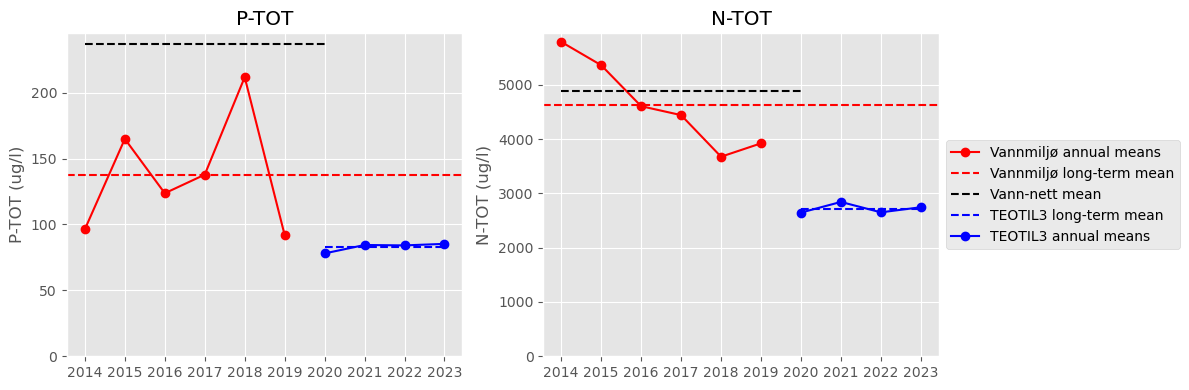

In [11]:
# Plot
df = obs_df.groupby(["ParameterID", "Year"])["RegValue"].mean().reset_index()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for idx, par in enumerate(vm_par_ids):
    par_df = df.query("ParameterID == @par").sort_values("Year")
    obs_mean = par_df["RegValue"].mean()
    axes[idx].plot(
        par_df["Year"], par_df["RegValue"], "ro-", label="Vannmiljø annual means"
    )
    axes[idx].axhline(obs_mean, ls="--", c="r", label="Vannmiljø long-term mean")
    if par == "N-TOT":
        teo_mean = totn_res_dict["conc_df"]["TOTN_ug/l"].mean()
        # teo2_mean = teo2_df["TOTN_ug/l"].mean()
        axes[idx].plot(
            [vn_st_yr, vn_end_yr], [totn_ugpl, totn_ugpl], "k--", label="Vann-nett mean"
        )
        # axes[idx].plot(
        #     [teo_st_yr, teo_end_yr],
        #     [teo2_mean, teo2_mean],
        #     "g--",
        #     label="TEOTIL2 long-term mean",
        # )
        axes[idx].plot(
            [teo_st_yr, teo_end_yr],
            [teo_mean, teo_mean],
            "b--",
            label="TEOTIL3 long-term mean",
        )
        totn_res_dict["conc_df"][["TOTN_ug/l"]].plot(
            ax=axes[idx],
            legend=False,
            marker="o",
            c="b",
        )
        axes[idx].lines[-1].set_label("TEOTIL3 annual means")
        # teo2_df["TOTN_ug/l"].plot(
        #     ax=axes[idx],
        #     legend=False,
        #     marker="o",
        #     c="g",
        # )
        # axes[idx].lines[-1].set_label("TEOTIL2 annual means")
    else:
        teo_mean = totp_res_dict["conc_df"]["TOTP_ug/l"].mean()
        # teo2_mean = teo2_df["TOTP_ug/l"].mean()
        axes[idx].plot(
            [vn_st_yr, vn_end_yr], [totp_ugpl, totp_ugpl], "k--", label="Vann-nett mean"
        )
        # axes[idx].plot(
        #     [teo_st_yr, teo_end_yr],
        #     [teo2_mean, teo2_mean],
        #     "g--",
        #     label="TEOTIL2 long-term mean",
        # )
        axes[idx].plot(
            [teo_st_yr, teo_end_yr],
            [teo_mean, teo_mean],
            "b--",
            label="TEOTIL3 long-term mean",
        )
        totp_res_dict["conc_df"][["TOTP_ug/l"]].plot(
            ax=axes[idx],
            legend=False,
            marker="o",
            c="b",
        )
        axes[idx].lines[-1].set_label("TEOTIL3 annual means")
        # teo2_df["TOTP_ug/l"].plot(
        #     ax=axes[idx],
        #     legend=False,
        #     marker="o",
        #     c="g",
        # )
        # axes[idx].lines[-1].set_label("TEOTIL2 annual means")
    axes[idx].set_title(par)
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel(f"{par} (ug/l)")
    axes[idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[idx].set_ylim(ymin=0)
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [12]:
# Approx. reference conditions
reg_df = (
    mod_df.query("regine == @reg_id").set_index("regine").mean(numeric_only=True).copy()
)

human = [
    "_agriculture_",
    "_aquaculture_",
    "_industry_",
    "_large-wastewater_",
    "_spredt_",
    "_urban_",
]
flow_litres = reg_df.loc["accum_q_m3/s"] * 60 * 60 * 24 * 365.25 * 1000
for par in ["totn", "totp", "toc"]:
    par_df = reg_df[
        [i.startswith("accum_") and (par in i) for i in reg_df.index]
    ].copy()
    hum_kg = par_df[
        [any(keyword in i for keyword in human) for i in par_df.index]
    ].sum()
    all_kg = par_df.sum()
    unit_fac = 1e6 if par == "toc" else 1e9
    unit = "mg/l" if par == "toc" else "ug/l"

    print(f"# {par.upper()}")
    print(f"  Human contribution: {100*hum_kg/all_kg:.1f}%")
    print(f"  Present:            {unit_fac * all_kg / flow_litres:.1f} {unit}")
    print(
        f"  Reference:          {unit_fac * (all_kg - hum_kg) / flow_litres:.1f} {unit}"
    )
    print("")

# TOTN
  Human contribution: 87.6%
  Present:            2853.1 ug/l
  Reference:          353.2 ug/l

# TOTP
  Human contribution: 91.0%
  Present:            89.1 ug/l
  Reference:          8.0 ug/l

# TOC
  Human contribution: 35.1%
  Present:            10.8 mg/l
  Reference:          7.0 mg/l

